# Task description and related information

The task is defined in file `Spectral Analysis Task Description.docx`. Shortly, our task is to analyse the provided NIRS (Near-infrared spectroscopy) dataset and create a prediction model for sample classification. NIRS is a non-invasive technique to measure concentration of various compounds in a sample. The technique is based on the absorption of near-infrared light. Result of NIRS on one sample is a series of numbers representing the intensity of a light in different wavelengths.

# Import libraries

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy.signal import savgol_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Load the dataset

In [2]:
spectra = pd.read_csv('spectra.csv')
X = spectra.iloc[:, 2:]
y = spectra.iloc[:, 1]

# split dataset to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# label numbers 1-9
labels = y.unique()

# Data exploration

In [3]:
# first look at provided data
spectra.head()

,Unnamed: 0,labels,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,601,602
0,1/02/2018,1,2.397526,2.394200,2.388952,2.381282,2.371906,2.360940,2.349092,2.336749,...,0.109473,0.111015,0.113123,0.115745,0.118939,0.122773,0.127250,0.132313,0.137997,0.144151
1,1/02/2018.1,1,2.399526,2.396723,2.391678,2.383280,2.372825,2.361160,2.348541,2.336346,...,0.108937,0.110649,0.112845,0.115586,0.118847,0.122642,0.127013,0.131837,0.137191,0.143028
2,1/02/2018.2,1,2.396475,2.393600,2.388446,2.380985,2.371319,2.359930,2.348114,2.336348,...,0.108358,0.110062,0.112391,0.115298,0.118736,0.122774,0.127359,0.132500,0.138217,0.144524
3,1/02/2018.3,1,2.406880,2.404243,2.399203,2.391142,2.380536,2.368569,2.356339,2.344046,...,0.110105,0.111836,0.114057,0.116744,0.119888,0.123524,0.127728,0.132561,0.138030,0.144085
4,1/02/2018.4,1,2.409883,2.407017,2.401310,2.392669,2.381365,2.368603,2.355518,2.342792,...,0.110129,0.111469,0.113277,0.115589,0.118503,0.122092,0.126346,0.131227,0.136840,0.143176


In [4]:
# info about the dataset size
spectra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Columns: 603 entries, Unnamed: 0 to 602
dtypes: float64(601), int64(1), object(1)
memory usage: 2.1+ MB


In [5]:
# make sure the column names are equivalent to interval 2-602 in correct order and without any missing numbers inbetween
list(spectra.columns)[2:] == [str(x) for x in list(range(2,603))]

True

In [6]:
# assign name to the first column which is the only one unnamed
spectra.rename(columns={'Unnamed: 0':'sample_measurment_id'}, inplace=True)
spectra.columns[0]

'sample_measurment_id'

In [7]:
spectra.describe()

,labels,2,3,4,5,6,7,8,9,10,...,593,594,595,596,597,598,599,600,601,602
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,...,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,5.000000,2.321074,2.318411,2.313219,2.305245,2.294997,2.283384,2.271419,2.259710,2.248041,...,0.113108,0.114627,0.116610,0.119091,0.122100,0.125650,0.129757,0.134425,0.139656,0.145435
std,2.584863,0.036340,0.036324,0.036232,0.036102,0.035918,0.035705,0.035473,0.035212,0.034955,...,0.005299,0.005288,0.005277,0.005267,0.005258,0.005250,0.005238,0.005226,0.005208,0.005190
min,1.000000,2.268786,2.266498,2.261299,2.253384,2.242729,2.230874,2.218569,2.206780,2.195687,...,0.104336,0.105957,0.107904,0.110365,0.113292,0.116627,0.120672,0.125333,0.130640,0.136488
25%,3.000000,2.295563,2.293171,2.288024,2.280553,2.270084,2.258338,2.246388,2.234668,2.223279,...,0.109184,0.110701,0.112780,0.115322,0.118390,0.121993,0.126047,0.130621,0.135842,0.141635
50%,5.000000,2.316178,2.313261,2.307872,2.300093,2.290049,2.278766,2.267296,2.255723,2.244021,...,0.112797,0.114180,0.116109,0.118580,0.121513,0.125040,0.129096,0.133807,0.139068,0.144987
75%,7.000000,2.332723,2.329958,2.324673,2.316915,2.306995,2.295170,2.282972,2.271433,2.259523,...,0.115544,0.117026,0.118934,0.121448,0.124492,0.127994,0.132076,0.136733,0.141910,0.147787
max,9.000000,2.427803,2.424886,2.418441,2.408555,2.396094,2.382773,2.369390,2.356514,2.344406,...,0.128351,0.129728,0.131623,0.134025,0.136916,0.140300,0.144660,0.149401,0.154445,0.160379


In [8]:
# check balance of measurments of individual samples
spectra['labels'].value_counts()

labels
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

In [9]:
# check for any duplicated rows
spectra.duplicated().sum()

0

In [10]:
# check for missing values
spectra.isnull().sum().sum()

0

Based on the provided task description and the above data exploration results we can assume several things:
1. The columns can be divided to three distinct parts:
    1. The first column was unnamed and it contains information about the ID of measurment on specific sample - we can assume it's a combination of date when the measurment took place plus an index of measurment that took place in that specific day on the sample with specific label (substance concentration).
    2. Column `labels` - information from the task description: "Individual labels represent different levels of concentration of a target substance in the analyzed sample. The higher the label number, the higher the concentration (1 = 0%. 9 = 100%)."
    3. Columns `2`-`602`. Exactly 601 columns for with measured NIRS values, each column representing one light wavelength value.
2. Based on the character of the dataset, there is no opportunity to create new features from existing ones.
3. The dataset is perfectly balanced with 50 measurments for each label.
4. There are no duplicated rows. If there were two rows with the exact same value, it could indicate that there was a mistake while inputting the measured data into the output CSV file.
5. There are no missing values. If there were any, we would have to consider ways to handle them. There are several ways to handle missing values - interpolation, forward/backward fill (if the data are collected over time), using algorithm such as K-nearest neighbours, etc.

## Visualisations

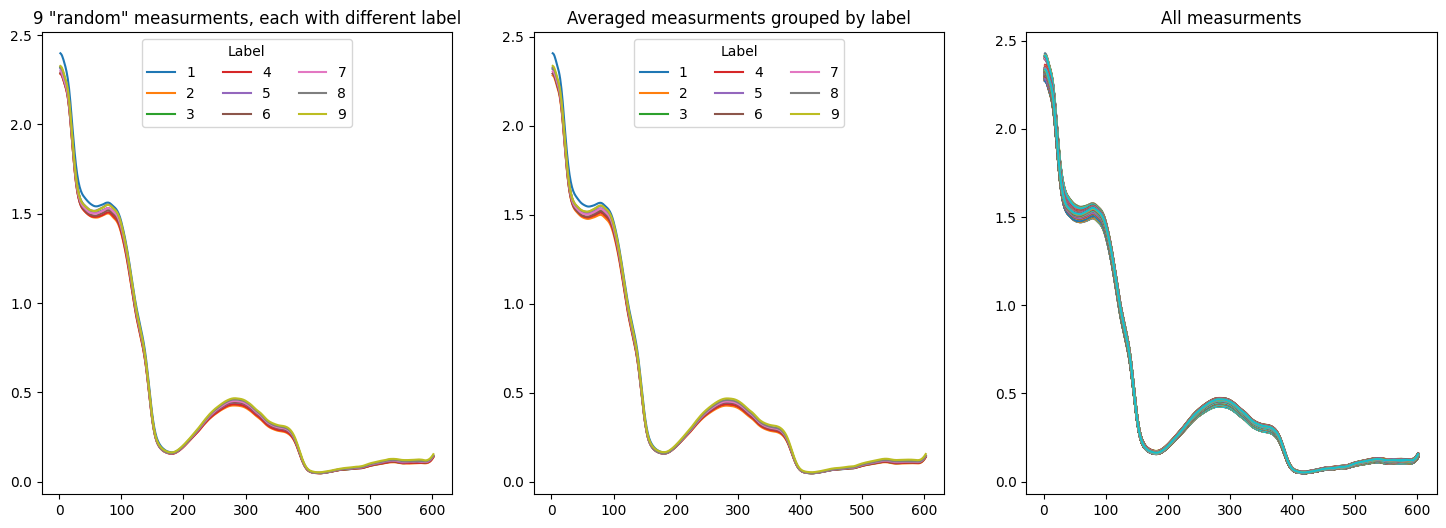

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
x_axis_values = np.asarray(range(2,603), float)

seed = random.randint(0, 49)
axs[0].set_title('9 "random" measurments, each with different label')
for ix in range(0, 450, 50):
    row_data = spectra.iloc[ix+seed, 2:]
    axs[0].plot(x_axis_values, row_data)

grouped_by_label = spectra.groupby('labels')
spectra_grouped_mean = grouped_by_label.mean(numeric_only=True)
axs[1].set_title('Averaged measurments grouped by label')
for ix in range(9):
    row_data = spectra_grouped_mean.iloc[ix]
    axs[1].plot(x_axis_values, row_data)

axs[2].set_title('All measurments')
for ix, row in spectra.iterrows():
    row_data = row[2:]
    axs[2].plot(x_axis_values, row_data)

axs[0].legend(labels, loc='upper center', ncol=3, title='Label')
axs[1].legend(labels, loc='upper center', ncol=3, title='Label')

At first glance, there is nothing abnormal or particularly interesting about these data and there is actually not much information we can gather just by looking at these charts. In unaltered state, all of the measurments are strongly correlated and there are only slight differences between them. The reason we cannot see any distinctive deviations is that the measurments consist of 601 features, most of which are strongly correleted across all labels. This high degree of dimensionality "hides" any relevant differences between the measurments with different labels. To obtain more useful information, we need to get rid of correlated components in the data by reducing its dimensionality. This will be done further down in this analysis.

We also showed a chart of all measurements just to see if there are not obvious outliers. Again, in this raw state of data there seems to be no outliers, but we will be able to make better judgement after we modify the dataset in the right way.

# Data pre-processing

## Data normalization

There are several widely used methods for data normalization in the spectral analysis field. These methods include calculating first derivative of data, Standard normal variate (SNV), Multiplicative scatter correction (MSC), data de-trending and several others. For now, we are going to use only one way of normalization - standard scaling of data - which is required by some machine learning methods to work properly. We are not using more normalization techniques because soon we will see that we are able to make very good predictions even with data that were only standardized.

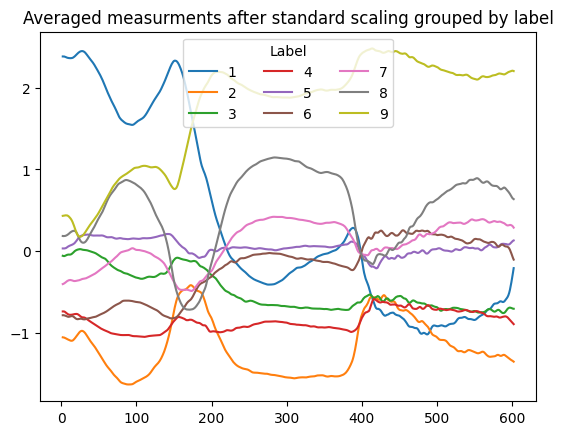

In [56]:
# visualisation of entire dataset after standard scaling
fig, ax = plt.subplots()
ax.set_title('Averaged measurments after standard scaling grouped by label')

std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

spectra_std = X_std.copy()
spectra_std['labels'] = y.reset_index(drop=True)
grouped_by_label = spectra_std.groupby('labels')
spectra_std_mean = grouped_by_label.mean(numeric_only=True)
for ix in range(9):
    row_data = spectra_std_mean.iloc[ix]
    ax.plot(np.asarray(range(2,603), float), row_data)
ax.legend(labels, loc='upper center', ncol=3, title='Label')

As we can see, averaged measurments of individual samples are already much more distinctive. This shows a good promise for our prediction models to reach good results.

## Dimensionality reduction

As was already mentioned, we need to reduce dimensionality of the data. Most of the features in our dataset are strongly correlated across all labels, which makes them basically useles as they can potentially decrease the ability of our prediction model to find relevant differences, based on which it classifies the samples. This many features also result in slower models, which could be an issue if we worked with much larger dataset.

### PCA - Principal component analysis

Text(0, 0.5, 'explained variance')

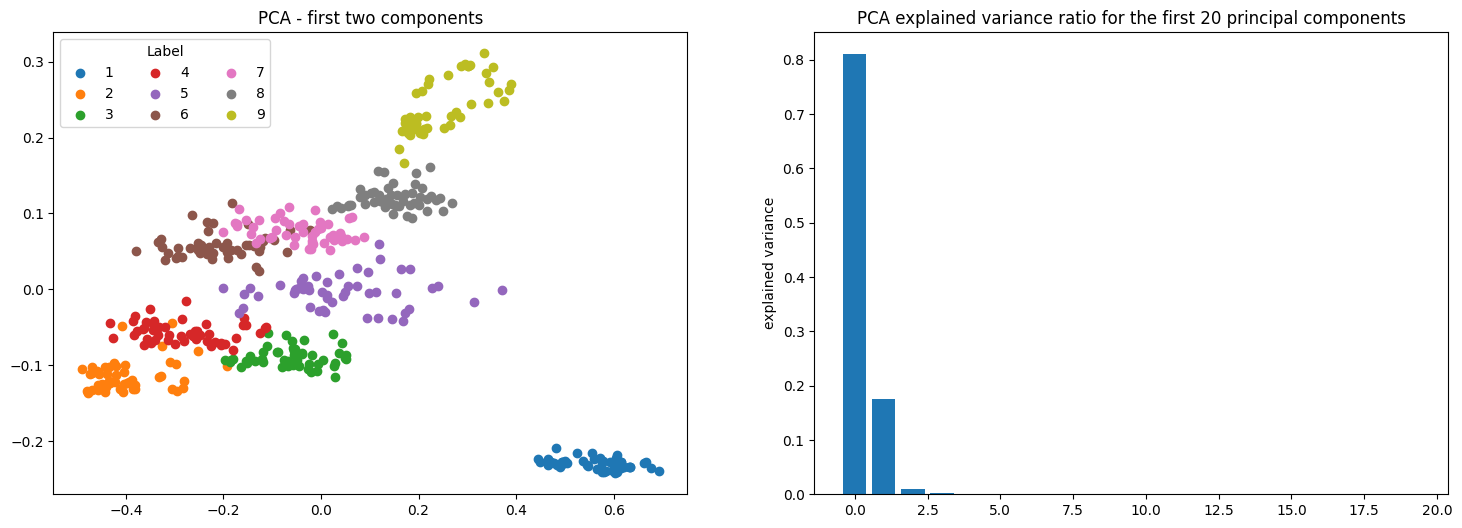

In [53]:
# visualisation of PCA of entire dataset
y_expanded = np.expand_dims(y, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].set_title('PCA - first two components')
axs[1].set_title('PCA explained variance ratio for the first 20 principal components')

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)
X_pca = np.transpose(X_pca)
X_pca = np.append(y_expanded, X_pca, axis=0)

for ix in labels:
    label_group = X_pca[:, X_pca[0]==ix]
    axs[0].scatter(label_group[1], label_group[2])
axs[0].legend(labels, loc='upper left', ncol=3, title='Label')

explained_variance_pca = pca.explained_variance_ratio_
axs[1].bar(range(0, len(explained_variance_pca)), explained_variance_pca)
axs[1].set_ylabel('explained variance')

In [16]:
print(np.cumsum(explained_variance_pca[:3])[-1])

0.995190182882126


We visualized the first two principal components of our PCA-processed data. As we can see, there are signs of separated clusters, but still only a few classes are clearly separated from the others. We calculated the explained variance of our PCA components and we can see that the first three principal components contribute to more than 99% of the total data variance. Therefore, the optimal n_components value for PCA on this dataset is **3**.

There is an opportunity to slightly finetune other hyperparameters of this method, but it's not in the scope of this work.

### LDA - Linear discriminant analysis

LDA is actually a machine learning algorithm used for classification, but because of the way it works it can also be used for dimensionality reduction. We will use this method later for creating on of our classification models, but we want to present its "functionality" by visualizing its results of dimensionality reduction.

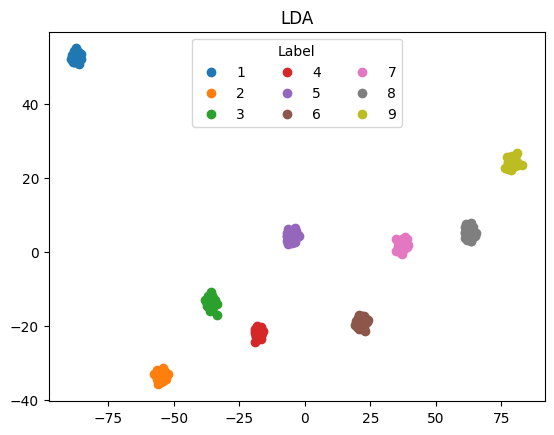

In [51]:
fig, ax = plt.subplots()
ax.set_title('LDA')

lda = LDA()
y_expanded = np.expand_dims(y, axis=0)

X_lda = lda.fit_transform(X_std, y)
X_lda = np.transpose(X_lda)
X_lda = np.append(y_expanded, X_lda, axis=0)

for ix in labels:
    label_group = X_lda[:, X_lda[0]==ix]
    ax.scatter(label_group[1], label_group[2])
ax.legend(labels, loc='upper center', ncol=3, title='Label')

LDA gives us even better visually separated clusters of analysed measurments. As well as with PCA, there is also an opportunity to finetune hyperparameters of this method to improve its results.

# Training prediction models

To create a prediction model for sample classification, we are going to use the results from previous section `Dimensionality reduction`. For this task, we will use two "classic" machine learning methods - LDA and Support vector machines (SVM). Also, we will train our own simple neural network to compare its results with the results of classic methods. We are using Pipelines from `sklearn` library for conveniet chaining of data pre-processing (standard scaling) and modeling.

## LDA - Linear discriminant analysis

#### Standardized data

In [67]:
lda_std = make_pipeline(StandardScaler(), LDA())
y_pred_lda_std = cross_val_predict(lda_std, X, y, cv=5)
print(classification_report(y, y_pred_lda_std))

y_pred_lda_std_proba = cross_val_predict(lda_std, X, y, cv=5, method='predict_proba')
auc_score = roc_auc_score(y, y_pred_lda_std_proba, multi_class='ovr')
print(f'AUC score = {auc_score}') 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       0.94      0.96      0.95        50
           4       0.96      0.94      0.95        50
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

AUC score = 0.9994999999999999


#### PCA reduced data

In [68]:
lda_pca = make_pipeline(StandardScaler(), PCA(n_components=3), LDA())
y_pred_lda_pca = cross_val_predict(lda_pca, X, y, cv=5)
print(classification_report(y, y_pred_lda_pca))

y_pred_lda_pca_proba = cross_val_predict(lda_pca, X, y, cv=5, method='predict_proba')
auc_score = roc_auc_score(y, y_pred_lda_pca_proba, multi_class='ovr')
print(f'AUC score = {auc_score}') 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       0.94      1.00      0.97        50
           5       1.00      0.92      0.96        50
           6       0.98      1.00      0.99        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

AUC score = 0.9999222222222222


## Support vector machines (SVM) classifier

We are using default values for all hyperparameters. There is space for finetuning the hyperparameters, e.g. using grid search, but it's not in the scope of this work.

#### Standardized data

In [71]:
svc_std = make_pipeline(StandardScaler(), SVC())
y_pred_svc_std = cross_val_predict(svc_std, X, y, cv=5)
print(classification_report(y, y_pred_svc_std))

svc_std = make_pipeline(StandardScaler(), SVC(probability=True))
y_pred_svc_std_proba = cross_val_predict(svc_std, X, y, cv=5, method='predict_proba')
auc_score = roc_auc_score(y, y_pred_svc_std_proba, multi_class='ovr')
print(f'AUC score = {auc_score}') 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      0.98      0.99        50
           3       0.93      1.00      0.96        50
           4       0.98      0.94      0.96        50
           5       0.98      0.98      0.98        50
           6       1.00      1.00      1.00        50
           7       1.00      0.98      0.99        50
           8       0.98      1.00      0.99        50
           9       1.00      0.98      0.99        50

    accuracy                           0.98       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.98      0.98       450

AUC score = 0.9998055555555556


#### PCA reduced data

In [72]:
svc_pca = make_pipeline(StandardScaler(), PCA(n_components=3), SVC())
y_pred_svc_pca = cross_val_predict(svc_pca, X, y, cv=5)
print(classification_report(y, y_pred_svc_pca))

svc_pca = make_pipeline(StandardScaler(), SVC(probability=True))
y_pred_svc_pca_proba = cross_val_predict(svc_pca, X, y, cv=5, method='predict_proba')
auc_score = roc_auc_score(y, y_pred_svc_pca_proba, multi_class='ovr')
print(f'AUC score = {auc_score}') 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      0.98      0.99        50
           3       0.93      1.00      0.96        50
           4       0.94      0.94      0.94        50
           5       0.98      0.92      0.95        50
           6       1.00      0.98      0.99        50
           7       0.96      0.98      0.97        50
           8       0.98      1.00      0.99        50
           9       1.00      0.98      0.99        50

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

AUC score = 0.999788888888889


## Neural networks

Models based on neural networks are in most cases much more complex than most of the "classic" machine learning models. Also, we have achieved almost perfect prediction results for our dataset with only these classic methods. For these reasons, and for the reason of time constraints, we have not implemented any neural network-based solution.

There is an immense space for experimenting with various neural network architectures and there are many people who use these techniques for NIRS data classification and regression. Convolutional neural networks were mostly used for image data, but there many researchers who used them with great results for NIRS or NIRS-similar data. Another opportunity to use neural networks is with dimensionality reduction - auto-encoder architecture can be used for this type of task.

# Results

The best results were achieved using LDA classifier with PCA reduced data. Because of time constraints the neural network model was not implemented. With more time dedicated to the task, this analysis can be expanded by experimenting with various data-preprocessing techniques, implementing different machine learning models including neural networks and also as finetuning models' hyperparameters.

|   Model  | Accuracy |Precision   | Recall | F1-score | ROC AUC score
|---|---|---|---|---|---|
|LDA (standardized data)   |0.99|0.99|0.99|0.99|0.99|
|LDA (PCA data)  | 0.99  |0.99|0.99|0.99|0.99|
|SVM (standardized data)   |0.98|0.99|0.98|0.98|0.99|
|SVM (PCA data)   |0.98|0.98|0.98|0.98|0.99|